Files already downloaded and verified
Files already downloaded and verified
Output Shape: torch.Size([3, 28, 28])


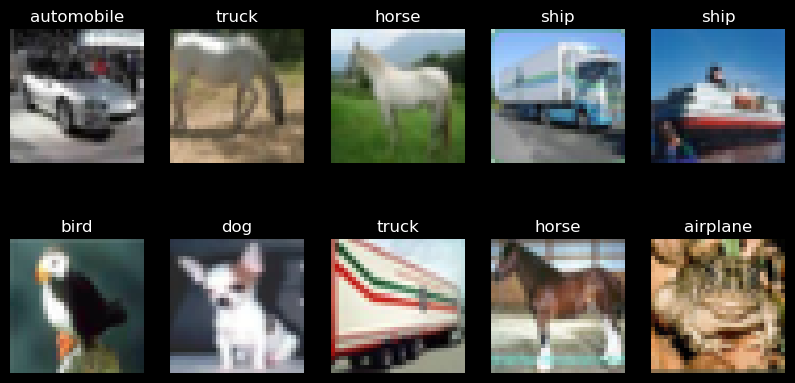

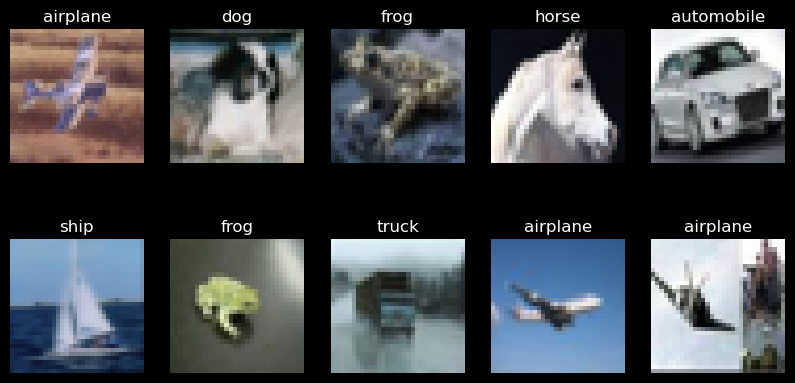

In [20]:
from generalization.randomization.transforms import get_cifar10_transforms
from generalization.randomization import create_corrupted_dataset
from generalization.randomization.utils import image_grid

from fastai.vision.all import *

import numpy as np

from IPython.display import clear_output, DisplayHandle


def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)


DisplayHandle.update = update_patch


def get_num_cpus():
    return len(os.sched_getaffinity(0))


def check(learn, dl, plt_title=None):
    y_pred, ys, losses = learn.get_preds(1, dl=dl, with_loss=True, reorder=True)

    print(y_pred[0].min(), y_pred[0].max(), y_pred[0].sum())
    print(y_pred[0].argmax(), ys[0], losses[0])
    plot_losses(losses, width=1, plt_title=plt_title)


def plot_losses(losses, width=1, plt_title=None):
    plt.bar(np.arange(len(losses)), losses, width=width)
    plt.title(plt_title)
    plt.show()


base_transforms = get_cifar10_transforms()
train_dset = create_corrupted_dataset(
    dataset_name="cifar10",
    corruption_name="partial_labels",
    corruption_prob=0.3,
    train=True,
    root="./data/cifar10",
    apply_corruption=True,
    return_corruption=False,
    transform=base_transforms,
)
test_dset = create_corrupted_dataset(
    dataset_name="cifar10",
    corruption_name="partial_labels",
    corruption_prob=0.3,
    train=False,
    root="./data/cifar10",
    apply_corruption=True,
    return_corruption=False,
    transform=base_transforms,
)

random_idxs = np.random.choice(len(test_dset), 10)
print("Output Shape:", test_dset[random_idxs[0]][0].shape)
image_grid(train_dset, random_idxs, no_transform=True)
image_grid(test_dset, random_idxs, no_transform=True)

In [21]:
from generalization.models import get_cifar_models

models = get_cifar_models()
print(models.keys())
net = models.get("inception_small")

# from torchinfo import summary

# batch_size = 32
# summary(net, input_size=(batch_size, 3, 28, 28))

dict_keys(['inception_small', 'alexnet', 'mlp_1x512', 'mlp_3x512'])


In [22]:
train_loader = torch.utils.data.DataLoader(
    train_dset, batch_size=256, shuffle=True, num_workers=get_num_cpus()
)

train_loader_ordered = torch.utils.data.DataLoader(
    train_dset, batch_size=512, shuffle=False, num_workers=get_num_cpus()
)

test_loader = torch.utils.data.DataLoader(
    test_dset, batch_size=512, shuffle=False, num_workers=get_num_cpus()
)

data = DataLoaders(train_loader, test_loader)
learn = Learner(
    data,
    net,
    loss_func=F.cross_entropy,
    # loss_func=CrossEntropyLossFlat(reduction='none'),
    opt_func=Adam,
    metrics=[accuracy, top_k_accuracy],
    cbs=EarlyStoppingCallback(monitor="accuracy", min_delta=0.01, patience=3),
)

In [ ]:
learn.fit(1, 1e-3)

tensor(-1.9421) tensor(1.4944) tensor(0.1429)
tensor(6) tensor(6) tensor(1.1533)


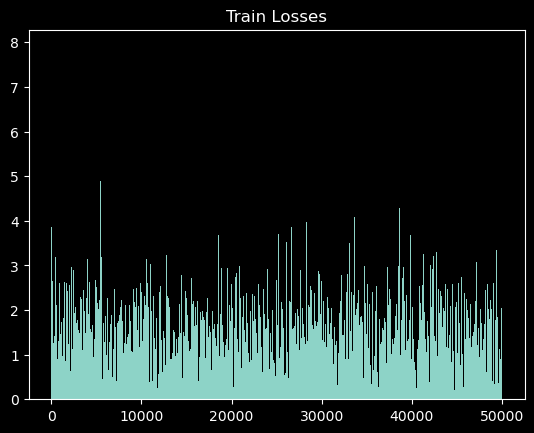

In [5]:
check(learn, train_loader_ordered, plt_title="Train Losses")

tensor(-0.9755) tensor(1.2385) tensor(0.1388)
tensor(6) tensor(3) tensor(1.3895)


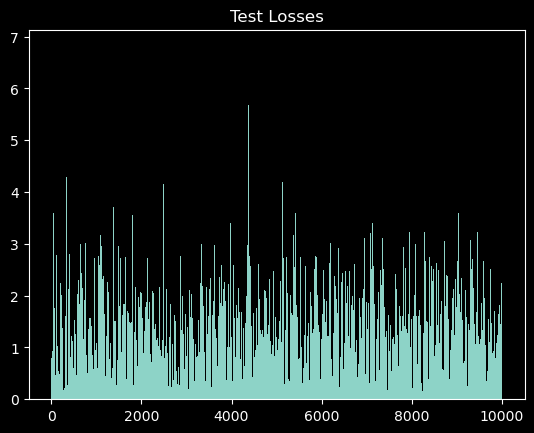

In [6]:
check(learn, test_loader, plt_title="Test Losses")

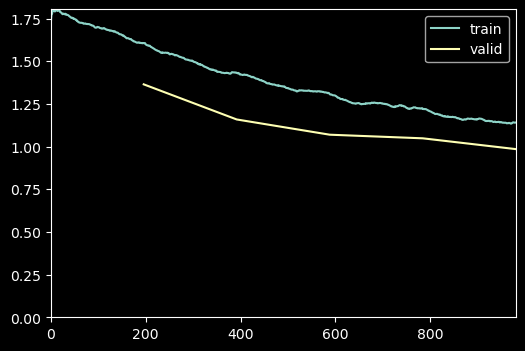

In [7]:
learn.fit(5, 1e-3)

tensor(-3.4820) tensor(3.7213) tensor(-0.4465)
tensor(6) tensor(6) tensor(0.4483)


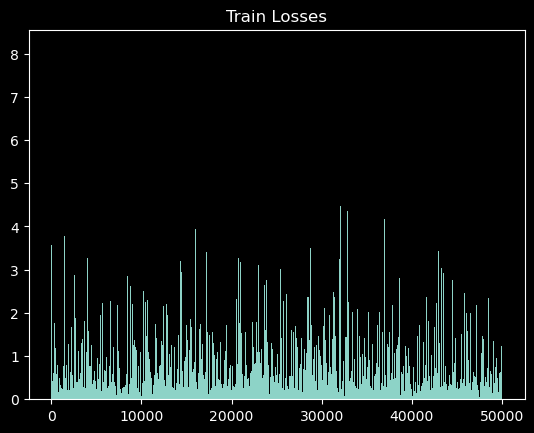

In [8]:
check(learn, train_loader_ordered, plt_title="Train Losses")

tensor(-4.5459) tensor(2.9207) tensor(-2.1257)
tensor(3) tensor(3) tensor(0.8956)


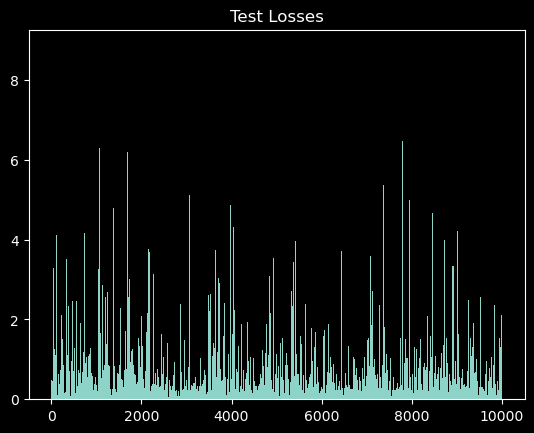

In [9]:
check(learn, test_loader, plt_title="Test Losses")